In [4]:
import pandas as pd
from pathlib import Path
import numpy as np
import rasterio as rio
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt

n_samples = 10
patch_ids = pd.read_csv("/ds2/remote_sensing/ben-ge/ffcv/write_indices/ben-ge-train60-delta.csv").head(n_samples)["patch_id"].to_list()

In [2]:
patch_ids

['S2B_MSIL2A_20170709T094029_7_54',
 'S2B_MSIL2A_20170814T100029_84_63',
 'S2A_MSIL2A_20171002T112112_64_39',
 'S2B_MSIL2A_20171219T095409_65_38',
 'S2A_MSIL2A_20171208T093351_66_83',
 'S2A_MSIL2A_20171002T112112_10_40',
 'S2A_MSIL2A_20180318T093031_14_47',
 'S2B_MSIL2A_20170802T092029_30_22',
 'S2A_MSIL2A_20170617T113321_73_83',
 'S2A_MSIL2A_20171104T095201_19_21']

## Visualize different Modalities ##

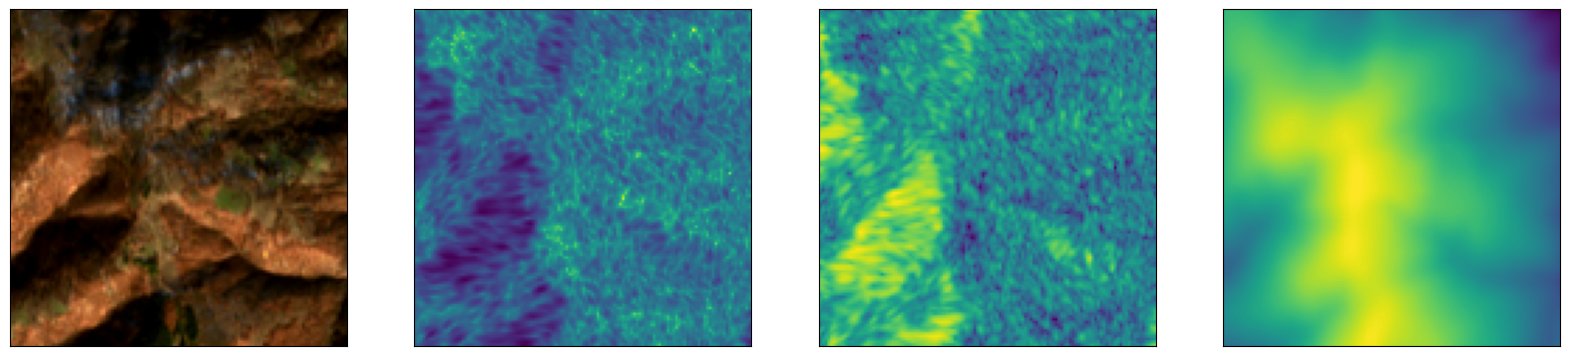

In [25]:
# Load Sentinel 1 Modality
sentinel_1_2_metadata = pd.read_csv("/ds2/remote_sensing/ben-ge/ben-ge/ben-ge_meta.csv")
patch_id = patch_ids[4]
s1_path_root = Path("/ds2/remote_sensing/ben-ge/ben-ge/sentinel-1/")
file_name_s1 = sentinel_1_2_metadata.loc[
    sentinel_1_2_metadata["patch_id"] == patch_id, "patch_id_s1"
].values[0]
s1_path = s1_path_root.joinpath(
    file_name_s1, file_name_s1 + "_all_bands.npy"
)
s1 = reshape_as_image(np.load(s1_path))
s1_vh = s1[:, :, [0]]
s1_vv = s1[:, :, [1]]

# Load Sentinel 2 Modality
s2_path_root = Path("/ds2/remote_sensing/ben-ge/ben-ge/sentinel-2/")
s2_path = s2_path_root.joinpath(
    patch_id, patch_id + "_all_bands.npy"
)
s2 = reshape_as_image(np.load(s2_path))[:, :, [3, 2, 1]]

# Load Altitude Modality
def load_rio(path):
    with rio.open(
        path
    ) as image_file:
        img = image_file.read()
    return img
dem_path = Path("/ds2/remote_sensing/ben-ge/ben-ge/glo-30_dem/")
dem_path = dem_path.joinpath(
    dem_path, patch_id + "_dem.tif"
)
dem = reshape_as_image(load_rio(dem_path))[:, :, 0]

fig, axs = plt.subplots(1, 4, figsize=(20,20))
axs = axs.flatten()
for i, img in enumerate([s2, s1_vh, s1_vv, dem]):
    axs[i].imshow(img / (img.max() + 0.0000001))
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_xticks([])
    axs[i].set_yticks([])

## Visualize Noise ##

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


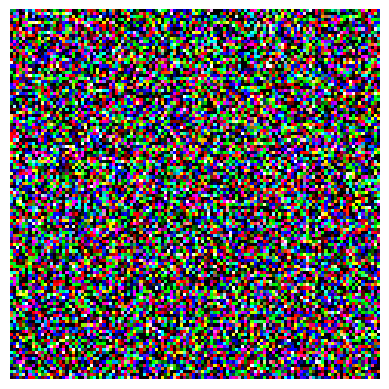

In [17]:
import torch

plt.clf()
plt.axis('off')
plt.imshow(torch.randn(120, 120, 3))

## Visualize Segmentation Map ##

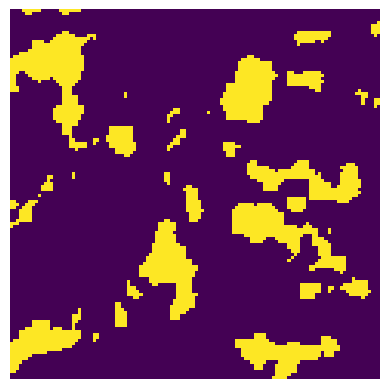

In [26]:
patch_id = patch_ids[4]

esa_world_cover_root_path = Path("/ds2/remote_sensing/ben-ge/ben-ge/esaworldcover/npy")
esa_world_cover_path = esa_world_cover_root_path.joinpath(patch_id +"_esaworldcover.npy")
esa_world_cover = reshape_as_image(np.load(esa_world_cover_path))
plt.axis('off')
plt.imshow(esa_world_cover)

In [28]:
unique, counts = np.unique(esa_world_cover, return_counts=True)

In [29]:
unique

array([10, 30], dtype=int8)

In [30]:
counts

array([11849,  2551])

In [31]:
2551 / (11849+2551)

0.17715277777777777

## Visualize Forward Diffusion process ##

In [41]:
import torch

from lit_diffusion.beta_schedule.beta_schedule import make_beta_schedule
from lit_diffusion.ddpm.util import extract_into_tensor


betas = torch.tensor(
    make_beta_schedule(
        schedule="linear",
        n_timestep=1000,
        linear_start=0.0001,
        linear_end=0.02,
    ),
    dtype=torch.float32,
    device=torch.device("cpu"),
    requires_grad=False,
)
alphas = 1.0 - betas

alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

def q_sample(
    x_start: torch.Tensor, t: torch.Tensor, sqrt_alphas_cumprod: torch.Tensor, sqrt_one_minus_alphas_cumprod: torch.Tensor, noise: torch.Tensor = None,
):
    """
    Diffuse the data for a given number of diffusion steps.

    In other words, sample from q(x_t | x_0).

    :param x_start: the initial data batch.
    :param t: the number of diffusion steps (minus 1). Here, 0 means one step.
    :param noise: if specified, the split-out normal noise.
    :return: A noisy version of x_start.
    """
    if noise is None:
        noise = torch.randn_like(x_start)
    assert noise.shape == x_start.shape
    return (
        extract_into_tensor(sqrt_alphas_cumprod, t, x_start.shape) * x_start
        + extract_into_tensor(sqrt_one_minus_alphas_cumprod, t, x_start.shape)
        * noise
    ), noise

In [99]:
# Min Max scale image
minimum = 0
maximum = 10000
interval_minimum = -1
interval_maximum = 1
scaled_s2 = ((s2 - minimum) / (maximum - minimum)) * (interval_maximum - interval_minimum) + interval_minimum

In [122]:
batch_size = 3

x_start = torch.Tensor(np.array([scaled_s2.astype("float32") for _ in range(batch_size)]))
t = torch.linspace(0, 999, steps=batch_size, dtype=torch.long)
output_imgs, noise = q_sample(
    x_start=x_start,
    t=t,
    sqrt_alphas_cumprod=sqrt_alphas_cumprod,
    sqrt_one_minus_alphas_cumprod=sqrt_one_minus_alphas_cumprod,
)

In [123]:
output_imgs = output_imgs.detach().numpy()
output_imgs.shape

(3, 120, 120, 3)

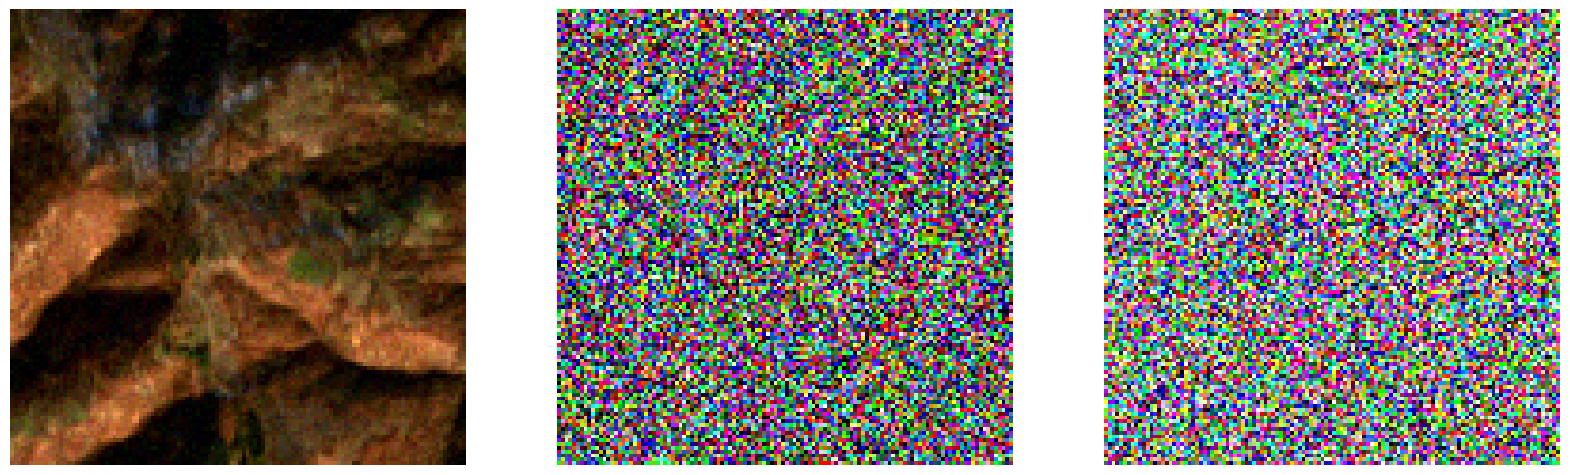

In [124]:
fig, axs = plt.subplots(1, len(output_imgs), figsize=(20, 20))
axs = axs.flatten()
for i in range(len(output_imgs)):
    current_img = output_imgs[i]
    current_img = ((current_img.clip(-1, 1) + 1) / 2 * 255)
    axs[i].imshow(current_img / current_img.max())
    axs[i].axis("off")